In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os, scipy.stats as stats
from neo.rawio import BlackrockRawIO
from neo.io import BlackrockIO


# pt 1: triggers but no units

In [3]:
# Define your trigger‐to‐name mapping
trigger_map = {
    10: 'Block started',
    20: 'Baseline started',
    30: 'Stim started',
    40: 'Delay started',
    50: 'Task started',
    51: 'Marker moved',
    52: 'Left pressed',
    53: 'Left released',
    54: 'Right pressed',
    55: 'Right released',
    56: 'Response submitted',
    60: 'Anticipation started',
    70: 'Feedback started',
    80: 'Block ended'
}

# Load the session with BlackrockIO (no extension on filename)
io_pt1 = BlackrockIO(filename='../results/202509/20250523-141833-002')
# io = BlackrockIO(filename='../results/20250717/20250717-143139-001')
block_pt1 = io_pt1.read_block(lazy=False)
seg_pt1 = block_pt1.segments[0]  # Assuming only one segment


```text
Block (entire recording session)  
└── Segment [0] (first/main recording segment)  
    ├── events (digital triggers, markers)  
    ├── analogsignals (continuous neural data)  
    └── spiketrains (spike times)

### triggers

In [4]:
# Find the digital‐input event stream
dig_ev = None
for ev in seg_pt1.events:
    if 'digital' in ev.name.lower():
        dig_ev = ev
        break
if dig_ev is None:
    raise RuntimeError("No digital‐input events found in NEV")

# Extract times (sec) and integer codes
times = dig_ev.times
codes = dig_ev.labels.astype(int)

# Sanity‐check: all expected codes are present
expected_codes = set(trigger_map.keys())
found_codes    = set(codes.tolist())
missing = expected_codes - found_codes
# if missing:
#     raise RuntimeError(f"Missing trigger codes: {sorted(missing)}")

# Build your trigger‐times dictionary
trig_times = {
    name: times[codes == code]
    for code, name in trigger_map.items()
}

print("Block starts (s):", trig_times['Block started'])
print("Block starts (mins):", trig_times['Block started'] / 60)
print()
print("Baseline starts (s):", trig_times['Baseline started'][:10])
print("Block ends (s):", trig_times['Block ended'])
print()

# align to first Baseline start and store as trig_Baseline_starts
trig_Baseline_starts = trig_times['Baseline started'] - trig_times['Block started'][0]
print("Baseline starts (aligned to first):", trig_Baseline_starts)

Block starts (s): [  37.26826667  299.53076667  558.33186667  809.76626667 1093.16743333
 1339.7519    ] s
Block starts (mins): [ 0.62113778  4.99217944  9.30553111 13.49610444 18.21945722 22.32919833] s

Baseline starts (s): [ 45.85056667  52.92976667  59.19643333  64.7965      70.6298
  76.56313333  82.96323333  88.6632      94.89653333 100.64656667] s
Block ends (s): [ 295.4531      553.9207      806.18866667 1063.15626667 1332.2239
 1590.7422    ] s

Baseline starts (aligned to first): [   8.5823       15.6615       21.92816667   27.52823333   33.36153333
   39.29486667   45.69496667   51.39493333   57.62826667   63.3783
   70.0117       75.76173333   82.0951       88.6284       95.19513333
  102.12853333  108.01186667  113.91186667  120.5452      128.09523333
  134.42866667  140.01203333  145.4787      151.61206667  158.42876667
  164.8621      170.86216667  176.9455      183.49556667  190.72886667
  196.8956      203.19563333  209.3123      215.59566667  221.16236667
  227.145666

### psychopy times

In [5]:
psychopy_df = pd.read_csv('../results/asymmetry_final_subj-202509_difficulty-patients_order-A_2025-05-23_14h44.58.284.csv')
psych_baseline_starts = psychopy_df['baseline.started'].values
# drop nans
psych_baseline_starts = psych_baseline_starts[~np.isnan(psych_baseline_starts)]
# align to first baseline start
psych_baseline_starts -= psych_baseline_starts[0]

psych_baseline_starts

array([   0.       ,    7.0793814,   13.3461886,   18.9464213,
         24.779852 ,   30.7133261,   37.1135751,   42.8136838,
         49.047167 ,   54.7973668,   61.4309327,   67.1810979,
         73.5146056,   80.0481008,   86.6149843,   93.5485467,
         99.4320405,  105.3321869,  111.965673 ,  119.5159172,
        125.8494879,  131.4329695,  136.8997809,  143.0333043,
        149.8501879,  156.2836762,  162.2838831,  168.3673584,
        174.9175792,  182.1510772,  188.3179725,  194.6181459,
        200.7349605,  207.0184862,  212.5853216,  218.5687816,
        224.8690116,  231.2692056,  237.3693919,  243.3362171,
        255.905963 ,  261.8367666,  269.0535287,  275.4704746,
        282.1873527,  288.3708458,  293.8376957,  299.7712092,
        305.9380302,  313.6049563,  319.5217369,  325.3886092,
        331.1387618,  337.3222205,  344.0723796,  350.8059869,
        356.6727478,  362.4396596,  368.2731338,  375.4233134,
        381.3234927,  387.3736539,  393.3738851,  399.2

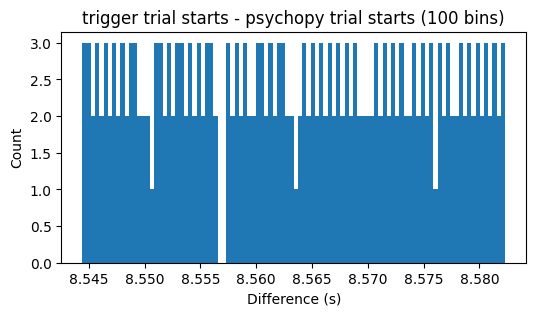

In [6]:
# ah, first need to convert trig_Baseline_starts to a list or arr or something
trig_Baseline_starts = np.array(trig_Baseline_starts)

bins = 100
plt.figure(figsize=(6, 3))
plt.hist(trig_Baseline_starts - psych_baseline_starts, bins=bins)
plt.xlabel('Difference (s)')
plt.ylabel('Count')
plt.title(f'trigger trial starts - psychopy trial starts ({bins} bins)')
plt.show()

# pt 2: no trigs but units

In [7]:
io_pt2    = BlackrockIO(filename='../results/20250717/20250717-143139-001')
block_pt2 = io_pt2.read_block(lazy=False)
seg_pt2   = block_pt2.segments[0]


## pseudo-spikes

In [8]:
print("spiketrains:", seg_pt2.spiketrains)

spiketrains: [<SpikeTrain(array([   7.4118    ,   12.1968    ,   12.25606667,   12.2918    ,
         12.401     ,   12.40313333,   13.7398    ,   21.68033333,
         58.78753333,   58.789     ,   59.2582    ,   63.62526667,
         63.64126667,   63.65986667,   64.03033333,   64.0324    ,
         64.03413333,   64.03573333,   64.03786667,   64.0396    ,
         64.04113333,   65.117     ,   66.33913333,   67.30213333,
         91.2866    ,  123.4676    ,  123.902     ,  438.999     ,
        439.11926667,  439.16806667,  439.22653333,  439.24666667,
        439.25813333,  439.2776    ,  439.28406667,  439.85433333,
        440.19546667,  440.2082    ,  440.21886667,  441.02013333,
        450.51      ,  450.7256    ,  450.75833333,  452.9842    ,
        453.28786667,  453.50386667,  453.5584    ,  453.56353333,
        453.56946667,  453.5902    ,  453.61106667,  453.62273333,
        453.6256    ,  453.62726667,  453.6284    ,  453.6832    ,
        453.68486667,  453.82753333,

In [9]:
for i, st in enumerate(seg_pt2.spiketrains):
    print(f"SpikeTrain #{i}:")
    print("  name:",       st.name)                             # e.g. "unit_1" or "Unit #2"
    print("  channel id:", st.annotations.get('channel_id'))    # e.g. 22
    print("  source id:",  st.annotations.get('source_id'))     # e.g. "NEV:Unit #2"
    print()


SpikeTrain #0:
  name: ch97#0
  channel id: 97
  source id: None

SpikeTrain #1:
  name: ch98#0
  channel id: 98
  source id: None

SpikeTrain #2:
  name: ch99#0
  channel id: 99
  source id: None

SpikeTrain #3:
  name: ch100#0
  channel id: 100
  source id: None

SpikeTrain #4:
  name: ch101#0
  channel id: 101
  source id: None

SpikeTrain #5:
  name: ch102#0
  channel id: 102
  source id: None

SpikeTrain #6:
  name: ch103#0
  channel id: 103
  source id: None

SpikeTrain #7:
  name: ch104#0
  channel id: 104
  source id: None

SpikeTrain #8:
  name: ch105#0
  channel id: 105
  source id: None

SpikeTrain #9:
  name: ch106#0
  channel id: 106
  source id: None

SpikeTrain #10:
  name: ch107#0
  channel id: 107
  source id: None

SpikeTrain #11:
  name: ch108#0
  channel id: 108
  source id: None

SpikeTrain #12:
  name: ch109#0
  channel id: 109
  source id: None

SpikeTrain #13:
  name: ch110#0
  channel id: 110
  source id: None

SpikeTrain #14:
  name: ch111#0
  channel id: 111


## lfp

### all signals

In [10]:
for idx, sig in enumerate(seg_pt2.analogsignals):
    print(f"--- Signal #{idx} ---")
    print(" name:            ", repr(sig.name))
    print(" sampling_rate:   ", sig.sampling_rate)
    print(" units:           ", sig.units)
    print(" shape (t, ch):  ", sig.shape)
    print(" annotations:     ", sig.annotations)  
    print(" array_annotations keys:", sig.array_annotations.keys())
    print(" array_annotations:", sig.array_annotations)
    print()

--- Signal #0 ---
 name:             'Channels: (chan1 chan2 chan3 chan4 chan5 chan6 chan7 chan8 chan9 chan10 chan11 chan12 chan13 chan14 chan15 chan16 chan17 chan18 chan19 chan20 chan21 chan22 chan23 chan24 chan25 chan26 chan27 chan28 chan29 chan30 chan31 chan32 chan33 chan34 chan35 chan36 chan37 chan38 chan39 chan40 chan41 chan42 chan43 chan44 chan45 chan46 chan47 chan48 chan49 chan50 chan51 chan52 chan53 chan54 chan55 chan56 chan57 chan58 chan59 chan60 chan61 chan62 chan63 chan64 chan65 chan66 chan67 chan68 chan69 chan70 chan71 chan72 chan73 chan74 chan75 chan76 chan77 chan78 chan79 chan80 chan81 chan82 chan83 chan84 chan85 chan86 chan87 chan88 chan89 chan90 chan91 chan92 chan93 chan94 chan95 chan96 chan97 chan98 chan99 chan100 chan101 chan102 chan103 chan104 chan105 chan106 chan107 chan108 chan109 chan110 chan111 chan112 chan113 chan114 chan115 chan116 chan117 chan118 chan119 chan120 chan121 chan122 chan123 chan124 chan125 chan126 chan127 chan128)'
 sampling_rate:    1000.0 Hz
 uni

| Stream    | nsx | Rate   | # channels | What’s in it                  |
| --------- | --- | ------ | ---------- | ----------------------------- |
| Signal #0 | NS2 | 1 kHz  | 128        | Downsampled LFP (electrodes)  |
| Signal #1 | NS2 | 1 kHz  | 4          | EyeX/EyeY/Pupil/BP (aux)      |
| Signal #2 | NS5 | 30 kHz | 4          | Sync/PD/AUD/CT (timing lines) |
| Signal #3 | NS6 | 30 kHz | 32         | Raw microwire voltages        |


### ns5: behavioral

In [11]:
ns5_sig = [
        sig for sig in seg_pt1.analogsignals
        if sig.annotations.get('nsx') == 5
      ][0]

print(" name:            ", ns5_sig.name)
print(" sampling_rate:   ", ns5_sig.sampling_rate)
print(" units:           ", ns5_sig.units)
print(" shape (t, ch):  ", ns5_sig.shape)
print(" time vector unit:", ns5_sig.times.units)
print(" annotations:     ", ns5_sig.annotations)
print(" array_annotations keys:", ns5_sig.array_annotations.keys())
print(" array_annotations:", ns5_sig.array_annotations)
print()


 name:             nsx5
 sampling_rate:    30000.0 Hz
 units:            1.0 mV
 shape (t, ch):   (48317070, 4)
 time vector unit: 1.0 s
 annotations:      {'stream_id': np.str_('5'), 'nsx': 5}
 array_annotations keys: dict_keys(['channel_names', 'channel_ids', 'physical_connector', 'connector_pin', 'hi_freq_corner', 'lo_freq_corner', 'hi_freq_order', 'lo_freq_order', 'hi_freq_type', 'lo_freq_type'])
 array_annotations: {'channel_names': array(['Sync', 'PD', 'AUD', ' CT'], dtype='<U4'), 'channel_ids': array(['129', '133', '135', '136'], dtype='<U3'), 'physical_connector': array([5, 5, 5, 5], dtype=uint8), 'connector_pin': array([1, 5, 7, 8], dtype=uint8), 'hi_freq_corner': array([0, 0, 0, 0], dtype=uint32), 'lo_freq_corner': array([0, 0, 0, 0], dtype=uint32), 'hi_freq_order': array([0, 0, 0, 0], dtype=uint32), 'lo_freq_order': array([0, 0, 0, 0], dtype=uint32), 'hi_freq_type': array([0, 0, 0, 0], dtype=uint16), 'lo_freq_type': array([0, 0, 0, 0], dtype=uint16)}



Sync – often the experiment’s master timing pulse  
PD (Photodiode) – to mark visual‐stimulus frames  
AUD – an audio channel (maybe a click or tone)  
CT (Cue Trigger) – an analog trigger from your task code

In [26]:
# pull out pd channel data
pd_waveform = ns5_sig[:, 3]
pd_times = ns5_sig.times
print(pd_waveform.shape)
print(pd_times.shape)

(48317070, 1)
(48317070,)


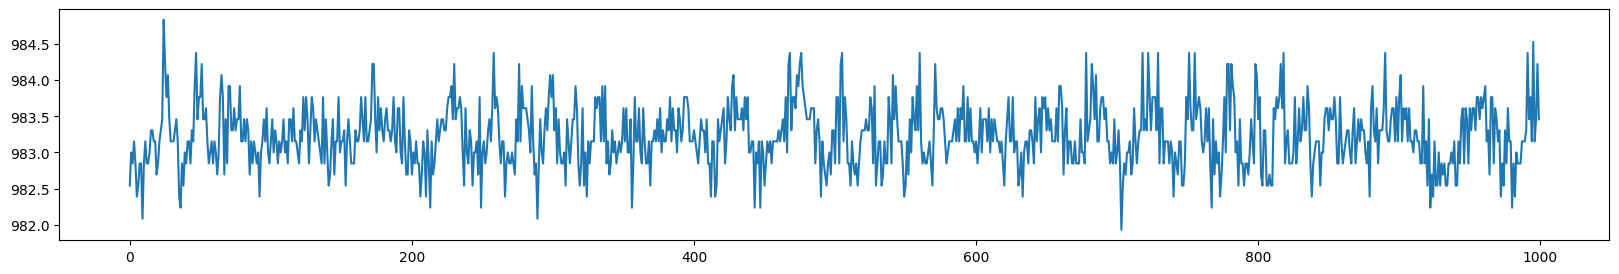

In [29]:
plt.figure(figsize=(20, 3))
plt.plot(pd_waveform[:1000])
# plt.ylim([-2, 2])
plt.show()

In [14]:
import numpy as np
from scipy.ndimage import uniform_filter1d
from neo import AnalogSignal

# 1. Pull out the raw samples and original units/rate
orig_units = ns5_sig.units              # e.g. ‘mV’
sr = ns5_sig.sampling_rate              # e.g. 10000 Hz
pd_data = ns5_sig.view(np.ndarray).squeeze()  # shape (n_samples, ch)
# if pd is channel 0:
pd_channel = pd_data[:, 0]              # plain NumPy, still with garbage units

# 2. Compute the running‐mean baseline and detrend
window_len = 101
baseline = uniform_filter1d(pd_channel, size=window_len, mode='reflect')
detrended_channel = pd_channel - baseline

# 3. Wrap back into an AnalogSignal (so you keep timestamps & units)
detrended = AnalogSignal(
    detrended_channel.reshape(-1, 1),   # back to (n_samples, 1)
    sampling_rate=sr,
    units=orig_units
)


## ns6: lfp to extract spikes from

In [15]:
ns6_sig = [
        sig for sig in seg_pt2.analogsignals
        if sig.annotations.get('nsx') == 6
      ][0]

print(" name:            ", ns6_sig.name)
print(" sampling_rate:   ", ns6_sig.sampling_rate)
print(" units:           ", ns6_sig.units)
print(" shape (t, ch):  ", ns6_sig.shape)
print(" time vector unit:", ns6_sig.times.units)
print(" annotations:     ", ns6_sig.annotations)
print(" array_annotations keys:", ns6_sig.array_annotations.keys())
print(" array_annotations:", ns6_sig.array_annotations)
print()


 name:             nsx6
 sampling_rate:    30000.0 Hz
 units:            1.0 uV
 shape (t, ch):   (47026304, 32)
 time vector unit: 1.0 s
 annotations:      {'stream_id': np.str_('6'), 'nsx': 6}
 array_annotations keys: dict_keys(['channel_names', 'channel_ids', 'physical_connector', 'connector_pin', 'hi_freq_corner', 'lo_freq_corner', 'hi_freq_order', 'lo_freq_order', 'hi_freq_type', 'lo_freq_type'])
 array_annotations: {'channel_names': array(['chan97', 'chan98', 'chan99', 'chan100', 'chan101', 'chan102',
       'chan103', 'chan104', 'chan105', 'chan106', 'chan107', 'chan108',
       'chan109', 'chan110', 'chan111', 'chan112', 'chan113', 'chan114',
       'chan115', 'chan116', 'chan117', 'chan118', 'chan119', 'chan120',
       'chan121', 'chan122', 'chan123', 'chan124', 'chan125', 'chan126',
       'chan127', 'chan128'], dtype='<U7'), 'channel_ids': array(['97', '98', '99', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '114',

There are 47 026 304 timepoints, so about 1 570 s (≈ 26 min) of recording at 30 000 Hz.